In [32]:
import json
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import os
import sys
import argparse
import torch

sys.path.append(os.getcwd())

# import src.data.data as data
import src.data.config as cfg
import src.interactive.functions as interactive

import json
import random

import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  

In [3]:
s = "string. With. Punctuation?" # Sample string 
s.translate(str.maketrans('', '', string.punctuation))

'string With Punctuation'

In [4]:
example_sent = "This is a sample sentence, showing off the stop words filtration."
stop_words = set(stopwords.words('english')) 
word_tokens = word_tokenize(example_sent) 
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  

In [5]:
# DUMP_FILE = '../../data/personachat_self_original_comet.json'
DUMP_FILE = '../../data/personachat_self_original_comet_validation.json'  # ** VALIDATION SPLIT ONLY

In [6]:
def load_data(dump_fname):
    annotated_data = json.load(open(dump_fname,'r'))
    return annotated_data

In [7]:
annotated_data = load_data(DUMP_FILE)

In [8]:
annotated_data.keys()

dict_keys(['valid'])

In [9]:
split = 'valid'

In [10]:
len(annotated_data), len(annotated_data[split]), annotated_data[split][0].keys()

(1, 1000, dict_keys(['personality', 'utterances', 'coment_annotation']))

In [11]:
# annotated_data['train']

In [12]:
annotated_data[split][0]['coment_annotation']

[{'sent': 'i read twenty books a year .',
  'comet': {'oEffect': {'event': 'i read twenty books a year .',
    'effect_type': 'oEffect',
    'beams': ['none',
     'they get a good grade',
     'wants to read more',
     'they learn about the books',
     'they learn about the book']},
   'oReact': {'event': 'i read twenty books a year .',
    'effect_type': 'oReact',
    'beams': ['none', 'happy', 'interested', 'impressed', 'proud']},
   'oWant': {'event': 'i read twenty books a year .',
    'effect_type': 'oWant',
    'beams': ['none',
     'to teach them more',
     'to read more books',
     'to read more',
     'to teach them']},
   'xAttr': {'event': 'i read twenty books a year .',
    'effect_type': 'xAttr',
    'beams': ['intelligent', 'studious', 'intellectual', 'smart', 'educated']},
   'xEffect': {'event': 'i read twenty books a year .',
    'effect_type': 'xEffect',
    'beams': ['gains knowledge',
     'learns a lot',
     'learns something new',
     'none',
     'learns 

In [13]:
len(annotated_data[split][0]['utterances']), annotated_data[split][0]['utterances'][0]

(8,
 {'candidates': ['oh really ? i am actually in high school and i am graduating as class of 2019 !',
   "that's an interesting choice . i'd have to pick french fries",
   'i just got a pet fish for my 18th birthday yesterday from my parents .',
   'yeah , well what about you ?',
   'my favorite watch is the rolex ? what is yours ?',
   "what is in spain that's so interesting",
   "i don't like clowns . they are scary to a kid like me",
   'poetry . roses are red . violet are . . . ?',
   'my father is a member of the army , served for 10 years now .',
   'oh i like mexican food , but my favorite food are cheeseburgers',
   'hey there , are you a mother ?',
   "it sure is . i'd like to see more of the city though .",
   'it is not so fun i have 2 friend who speak a different langues',
   "i'd like some honey though . do you sell it ?",
   'i am a recovering heavy drinker . full time . how about you ?',
   'hi ! i have three kids . how many do you have ?',
   'awesome ! i own 2 dogs ,

In [14]:
annotated_data[split][0]['utterances'][1]

{'candidates': ['why have you not sent help ? ! the scorpions are stinging my legs ! ree ! ! ! ! ! ! !',
  'that is great i am expecting twins in two months . will these be your first kids ?',
  'do you live on a farm or ranch ?',
  'hi how are you doing tonight i am fine .',
  "i'd love to see her do that .",
  "i don't . but i am so glad you do something that brings you joy",
  'it is hard , buy my dog keeps me company . do you have dogs ?',
  'sounds like a good plan , what would you like to teach ?',
  'i like rap music and i also produce for music artists .',
  'where do you work ?',
  'i broke my arm so i can not drink coffee',
  "i meant mickey . cool i've a lot of friends and love the playground . do you ?",
  'oh , yes . i wish i could skate to school . i ride the bus instead .',
  'that is my idea of heaven . i love bunnies ! i donate to a bunny charity too .',
  'i work on a freelance basis as an author , blogger and affiliate marketer . and you ?',
  'like me ? would you go

In [15]:
annotated_data[split][0]['utterances'][-1]

{'candidates': ['fun , i should take my kids out to do that . do you have a family ?',
  'they were popular in my younger days lol',
  'i sing and love rock especially while working . keeps me pumped .',
  'i mean where i come from kitties do not play with birds .',
  'i tend my rose garden and read books . i am deaf in one ear',
  'you can learn to say something nice and smart',
  'when in europe all i do is shop',
  'wow , that is exciting ! i never went to a nascar race .',
  'i live in hawaii and i work from home .',
  'hello jennifer , i am a proud dad and husband',
  'and my spouse used all the money i earned',
  'oh young people . the holidays are coming . that makes me sad .',
  'i had surgery last week and now i think of an object , and it moves !',
  'hello ! i just got back from a run . what are you up to today ?',
  'hello , my name is ally and my favourite color is orange',
  "no i didn't see that . i am excited for the new star wars though",
  'that is exciting ! do you g

In [47]:
def process_text(s, typ='unigram', rem_stop=True):
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(s) 
    filtered_sentence = word_tokens
    if rem_stop:
        filtered_sentence = [w for w in filtered_sentence if not w in stop_words] 
    if typ=='bigram':
        filtered_sentence = [ '_'.join(filtered_sentence[i:i+2]) for i in range(len(filtered_sentence)-1) ] 
    return filtered_sentence
    

In [60]:
def get_detailed_report(history, all_personality_words, all_comet_sentences):
    ret = []
    for sent_h in history:
        for tok in sent_h:
            if tok in stop_words: # these are not interesting
                continue
            if tok not in all_personality_words:
                for sent in all_comet_sentences:
                    if tok in sent:
                        ret.append([tok,sent_h,sent])
    return ret
    

In [61]:
def process(item, typ='unigram', rem_stop=True, det_report=False):
    
    utterances = item['utterances']
    history = utterances[-1]['history']
    all_conversation_words = []
    all_conversation_sent = []
    for h in history:
        #print("history: ", h)
        tmp = process_text(h,typ=typ,rem_stop=rem_stop)
        all_conversation_words.extend(tmp)
        all_conversation_sent.append(tmp)
    all_conversation_words = set(all_conversation_words)

    personality = item['personality']
    all_personality_words = []
    for h in personality:
        #print("personality: ", h)
        all_personality_words.extend(process_text(h,typ=typ,rem_stop=rem_stop))
    all_personality_words = set(all_personality_words)
    
    coment_annotation = item['coment_annotation']
    all_comet_words = []
    all_comet_sentences = [] # stores list of processed sentences
    for h in coment_annotation:
        comet = h['comet']
        for _,value in comet.items():
            for sent in value['beams']:
                #print('coment_annotation: ',sent)
                if sent.strip() == 'none':
                    continue
                tmp = process_text(sent,typ=typ,rem_stop=rem_stop)
                all_comet_sentences.append(tmp)
                all_comet_words.extend(tmp)
    all_comet_words = set(all_comet_words)
    
    detailed_report=None
    if det_report:
        detailed_report = get_detailed_report(all_conversation_sent, all_personality_words, all_comet_sentences)
    
    
    conv_personality_overlap = len(all_conversation_words.intersection(all_personality_words)) / ( len(all_conversation_words) )
    conv_comet_overlap = len(all_conversation_words.intersection(all_comet_words)) /  ( len(all_conversation_words) )
    
    all_extended_personality_words = all_comet_words.union(all_personality_words)
    conv_ext_personality_overlap = len(all_conversation_words.intersection(all_extended_personality_words)) /  ( len(all_conversation_words) )
    
    additional_word_set = all_conversation_words.intersection(all_comet_words) - all_conversation_words.intersection(all_personality_words)
    
    #print("additional_word_set = ", additional_word_set)
    #print(conv_personality_overlap, conv_comet_overlap)
    
    return {'additional_word_set':additional_word_set, 
            'detailed_report':detailed_report,
            'conv_personality_overlap':conv_personality_overlap,
            'conv_comet_overlap':conv_comet_overlap,
            'conv_ext_personality_overlap':conv_ext_personality_overlap,
            'additional_recall':conv_ext_personality_overlap - conv_personality_overlap}
    

In [38]:
process(annotated_data[split][0])

{'additional_word_set': {'done', 'get', 'good', 'help', 'well', 'work'},
 'conv_personality_overlap': 0.1111111111111111,
 'conv_comet_overlap': 0.15873015873015872,
 'conv_ext_personality_overlap': 0.20634920634920634,
 'additional_recall': 0.09523809523809523}

In [ ]:
#additionalrecall possible --- unigrams without stopwordss

In [29]:
all_ret_split = []
for datum in annotated_data[split]:
    all_ret_split.append(process(datum))
len(all_ret_split)

1000

In [30]:
additional_recall_vals_split = [val['additional_recall'] for val in all_ret_split]
scipy.stats.describe(additional_recall_vals_split)

DescribeResult(nobs=1000, minmax=(0.0, 0.28125), mean=0.10200358608080372, variance=0.0017070346252220359, skewness=0.42867000470503713, kurtosis=0.29558621111059225)

(array([ 25.,  98., 234., 266., 208., 109.,  42.,  14.,   2.,   2.]),
 array([0.      , 0.028125, 0.05625 , 0.084375, 0.1125  , 0.140625,
        0.16875 , 0.196875, 0.225   , 0.253125, 0.28125 ]),
 <a list of 10 Patch objects>)

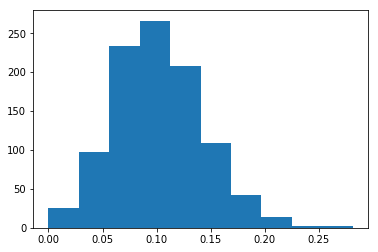

In [31]:
plt.hist(additional_recall_vals_split)

In [ ]:
### additional_word_set

In [36]:
additional_word_set_vals_split = []
for val in all_ret_split:
    additional_word_set_vals_split.extend( val['additional_word_set'] )
ctr = sorted( Counter(additional_word_set_vals_split).items(),key=lambda x:-x[1] )
ctr[:44], ctr[-22:]

([('good', 470),
  ('like', 327),
  ('get', 301),
  ('go', 250),
  ('fun', 237),
  ('well', 210),
  ('lot', 198),
  ('time', 146),
  ('work', 105),
  ('make', 99),
  ('new', 97),
  ('job', 96),
  ('know', 91),
  ('play', 77),
  ('thank', 70),
  ('money', 69),
  ('people', 67),
  ('enjoy', 65),
  ('eat', 64),
  ('home', 55),
  ('school', 51),
  ('nice', 50),
  ('help', 48),
  ('happy', 44),
  ('dog', 43),
  ('see', 42),
  ('take', 42),
  ('young', 40),
  ('better', 40),
  ('teach', 37),
  ('also', 35),
  ('hard', 34),
  ('music', 33),
  ('person', 31),
  ('family', 30),
  ('listen', 30),
  ('sure', 30),
  ('sad', 30),
  ('kids', 29),
  ('food', 29),
  ('things', 29),
  ('kind', 28),
  ('learn', 28),
  ('life', 27)],
 [('tan', 1),
  ('allergies', 1),
  ('dead', 1),
  ('teacher', 1),
  ('annoyed', 1),
  ('tell', 1),
  ('unhappy', 1),
  ('watched', 1),
  ('intelligent', 1),
  ('cry', 1),
  ('adopt', 1),
  ('service', 1),
  ('cake', 1),
  ('player', 1),
  ('control', 1),
  ('feed', 1),
  ('

In [ ]:
#additionalrecall possible --- bigrams with stopwords

In [43]:
all_ret_split = []
for datum in annotated_data[split]:
    all_ret_split.append(process(datum,typ='bigram',rem_stop=False))
len(all_ret_split)

1000

In [44]:
additional_recall_vals_split = [val['additional_recall'] for val in all_ret_split]
scipy.stats.describe(additional_recall_vals_split)

DescribeResult(nobs=1000, minmax=(0.0, 0.0891089108910891), mean=0.02670558813952201, variance=0.0002897037247020613, skewness=0.6778822229550405, kurtosis=0.15975328627713736)

(array([147., 220., 192., 154., 126.,  84.,  50.,  13.,   9.,   5.]),
 array([0.        , 0.00891089, 0.01782178, 0.02673267, 0.03564356,
        0.04455446, 0.05346535, 0.06237624, 0.07128713, 0.08019802,
        0.08910891]),
 <a list of 10 Patch objects>)

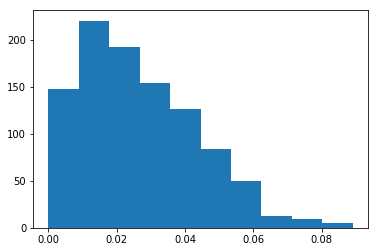

In [45]:
plt.hist(additional_recall_vals_split)

In [46]:
additional_word_set_vals_split = []
for val in all_ret_split:
    additional_word_set_vals_split.extend( val['additional_word_set'] )
ctr = sorted( Counter(additional_word_set_vals_split).items(),key=lambda x:-x[1] )
ctr[:44], ctr[-22:]

([('have_a', 211),
  ('a_lot', 196),
  ('to_be', 164),
  ('go_to', 116),
  ('lot_of', 113),
  ('to_go', 109),
  ('to_get', 98),
  ('to_the', 94),
  ('be_a', 79),
  ('to_have', 75),
  ('a_good', 71),
  ('for_a', 48),
  ('to_do', 42),
  ('in_the', 40),
  ('in_a', 39),
  ('get_a', 38),
  ('to_play', 34),
  ('of_the', 32),
  ('for_the', 31),
  ('to_make', 30),
  ('a_job', 29),
  ('listen_to', 29),
  ('is_a', 28),
  ('they_are', 28),
  ('a_new', 27),
  ('get_to', 27),
  ('like_to', 26),
  ('to_eat', 26),
  ('a_dog', 23),
  ('have_to', 22),
  ('to_school', 21),
  ('to_know', 19),
  ('on_the', 19),
  ('to_a', 17),
  ('to_read', 15),
  ('to_work', 15),
  ('i_like', 15),
  ('live_in', 15),
  ('to_learn', 15),
  ('to_listen', 13),
  ('on_a', 13),
  ('not_like', 12),
  ('how_to', 12),
  ('to_take', 12)],
 [('for_jobs', 1),
  ('well_in', 1),
  ('from_the', 1),
  ('a_doctor', 1),
  ('a_drink', 1),
  ('birthday_cake', 1),
  ('the_doctor', 1),
  ('they_play', 1),
  ('the_crops', 1),
  ('a_city', 1),


In [50]:
### see some examples of context in which additional words are present


In [62]:
all_ret_split = []
for datum in annotated_data[split]:
    all_ret_split.append(process(datum,typ='unigram',rem_stop=False,det_report=True))
len(all_ret_split)

1000

In [63]:
all_ret_split[0]

{'additional_word_set': {'about',
  'are',
  'at',
  'do',
  'done',
  'get',
  'good',
  'have',
  'help',
  'him',
  'is',
  'it',
  'me',
  'the',
  'them',
  'to',
  'too',
  'well',
  'work'},
 'detailed_report': [['good',
   ['i',
    'am',
    'good',
    'i',
    'just',
    'got',
    'off',
    'work',
    'and',
    'tired',
    'i',
    'have',
    'two',
    'jobs'],
   ['they', 'get', 'a', 'good', 'grade']],
  ['good',
   ['i',
    'am',
    'good',
    'i',
    'just',
    'got',
    'off',
    'work',
    'and',
    'tired',
    'i',
    'have',
    'two',
    'jobs'],
   ['to', 'get', 'a', 'good', 'grade']],
  ['good',
   ['i',
    'am',
    'good',
    'i',
    'just',
    'got',
    'off',
    'work',
    'and',
    'tired',
    'i',
    'have',
    'two',
    'jobs'],
   ['to', 'get', 'a', 'good', 'job']],
  ['good',
   ['i',
    'am',
    'good',
    'i',
    'just',
    'got',
    'off',
    'work',
    'and',
    'tired',
    'i',
    'have',
    'two',
    'jobs

In [70]:
def show_random_additional_oc_ctxt(all_ret_split):
    res = random.choice(all_ret_split)
    res = random.choice(res['detailed_report'])
    print(res)

In [71]:
for i in range(5):
    print(i)
    show_random_additional_oc_ctxt(all_ret_split)

0
['like', ['i', 'like', 'eating', 'papaya', 'when', 'i', 'am', 'sad'], ['like', 'a', 'good', 'listener']]
1
['safe', ['yeah', 'i', 'try', 'to', 'play', 'it', 'safe', 'and', 'stay', 'home', 'with', 'my', 'cats', 'and', 'dogs'], ['to', 'make', 'sure', 'they', 'are', 'safe']]
2
['go', ['money', 'makes', 'the', 'world', 'go', 'round'], ['to', 'go', 'to', 'spain']]
3
['get', ['nice', 'chatting', 'with', 'you', 'im', 'going', 'to', 'get', 'a', 'short', 'haircut', 'now'], ['to', 'get', 'exercise']]
4
['walking', ['i', 'like', 'walking', 'period', 'but', 'yes', 'especially', 'nature', 'walks', 'how', 'about', 'you'], ['to', 'like', 'walking']]


In [27]:
###########